<a href="https://colab.research.google.com/github/csaybar/EEwPython/blob/master/1_8_Iterations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!--COURSE_INFORMATION-->
<img align="left" style="padding-right:10px;" src="https://sitejerk.com/images/google-earth-logo-png-5.png" width=5% >
<img align="right" style="padding-left:10px;" src="https://colab.research.google.com/img/colab_favicon_256px.png" width=6% >


>> *This notebook is part from the free course [EEwPython](https://github.com/csaybar/EEwPython); the content is available [on GitHub](https://github.com/csaybar/EEwPython)* and released under the [Apache 2.0 License](https://www.gnu.org/licenses/gpl-3.0.en.html).

<!--NAVIGATION-->
 <[Spatial Temporal Reducers](1.7_Reducers.ipynb) | [Contents](index.ipynb) |  [Export Resutls](1.9_ExportResults.ipynb) >

<a href="https://colab.research.google.com/github/csaybar/EEwPython/blob/master/1.8_Iterations.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

In [0]:
#@title # Iterating over an ImageCollection
from IPython.display import HTML
HTML('<center><iframe width="560" height="315" src="https://www.youtube.com/embed/LzxQH0Ze0iI" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></center>')

In [0]:
#@title Function to visualize thumbnail URL
from IPython.display import Image
from IPython.display import HTML

def display_image(url,title="",CSS_row=False):
  img_link = "<center> <h1>%s</h1> <img title='%s' src= '%s'></center>" % (title,title,url)
  return HTML(img_link)

### Connecting GEE, Colab and Google Drive

- **Colab & Google Drive synchronization**

In [0]:
#from google.colab import drive
#drive.mount('/content/drive')

- **Colab & Earth Engine synchronization**

In [0]:
!pip install earthengine-api #Firstly we need the earth-engine API

In [0]:
!earthengine authenticate 

In [0]:
import ee
ee.Initialize()

### 1. Iterating over an ImageCollection

Although `map()` applies a function to every image in a collection, the function visits every image in the collection independently. For example, suppose you want to compute a cumulative anomaly ($A_t$) at time t from a time series. To obtain a recursively defined series of the form $A_t = f(Image_t, A_{t-1})$, mapping won't work because the function (f) depends on the previous result ($A{t-1}$). 

For example, suppose you want to compute a series of cumulative Normalized Difference Vegetation Index (NDVI) anomaly images relative to a baseline. Let $A_0 = 0$ and $f(Image_t, A_{t-1}) = Image_t + A_{t-1}$ where $A_{t-1}$ is the cumulative anomaly up to time $t-1$ and Image_t is the anomaly at time t. Use **imageCollection.iterate()** to make this recursively defined ImageCollection. In the following example, the function **accumulate()** takes two parameters: an image in the collection, and a list of all the previous outputs. With each call to **iterate()**, the anomaly is added to the running sum and the result is added to the list. The final result is passed to the **ImageCollection** constructor to get a new sequence of images:



In [0]:
# Load MODIS EVI imagery.
collection = ee.ImageCollection('MODIS/006/MYD13A1').select('EVI');

# Define reference conditions from the first 10 years of data.
reference = collection.filterDate('2001-01-01', '2010-12-31')\
                      .sort('system:time_start', False) # Sort chronologically in descending order.

# Compute the mean of the first 10 years.
mean = reference.mean()

# Compute anomalies by subtracting the 2001-2010 mean from each image in a
# collection of 2011-2014 images. Copy the date metadata over to the
# computed anomaly images in the new collection.
series = collection.filterDate('2011-01-01', '2014-12-31')\
                   .map(lambda img: img.subtract(mean).set('system:time_start', img.get('system:time_start')))

# Display cumulative anomalies.
roi = ee.Geometry.Rectangle(-100.811-1, 40.2-1,-100.811+1, 40.2+1)
geoviz = {'min': -60000, 'max': 60000, 'palette': ['FF0000', '000000', '00FF00']}
dimg_1 = series.sum().clip(roi).getThumbUrl(geoviz)

display_image(dimg_1,'EVI anomaly')    

In [0]:
# Get the timestamp from the most recent image in the reference collection.
time0 = reference.first().get('system:time_start')

# Use imageCollection.iterate() to make a collection of cumulative anomaly over time.
# The initial value for iterate() is a list of anomaly images already processed.
# The first anomaly image in the list is just 0, with the time0 timestamp.
first = ee.List([ee.Image(0).set('system:time_start', time0).select([0], ['EVI'])]) # Rename the first band 'EVI'.

# This is a function to pass to Iterate().
# As anomaly images are computed, add them to the list.
def accumulate(img,lista):
  # Get the latest cumulative anomaly image from the end of the list with
  # get(-1).  Since the type of the list argument to the function is unknown,
  # it needs to be cast to a List.  Since the return type of get() is unknown,
  # cast it to Image.
  img = ee.Image(img)
  previous = ee.Image(ee.List(lista).get(-1))
  # Add the current anomaly to make a new cumulative anomaly image.
  added = img.add(previous)\
               .set('system:time_start', img.get('system:time_start')) # Propagate metadata to the new image.
  # Return the list with the cumulative anomaly inserted.
  return ee.List(lista).add(added)

# Create an ImageCollection of cumulative anomaly images by iterating.
# Since the return type of iterate is unknown, it needs to be cast to a List.
cumulative = ee.ImageCollection(ee.List(series.iterate(accumulate, first)))

In [0]:
def stackCollection(collection):
  # Create an initial image.
  first = ee.Image(collection.first()).select([])

  # Write a function that appends a band to an image.
  def appendBands(image, previous):
    return ee.Image(previous).addBands(image)
  return ee.Image(collection.iterate(appendBands, first))

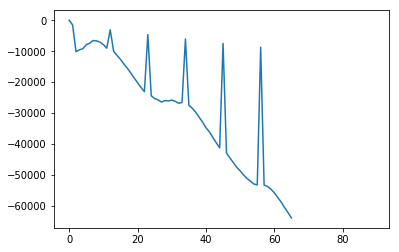

In [0]:
import numpy as np
import matplotlib.pyplot as plt

# Chart some interesting locations.
pt1 = ee.Geometry.Point(116.4647, 40.1054)

# ee.ImageCollection to ee.Image
img_cumulative = stackCollection(cumulative)


series = img_cumulative.reduceRegions(collection=pt1,
                                      reducer=ee.Reducer.mean(),
                                      scale=500)

dic_series = series.getInfo()
EVI_anom = np.array(list(dic_series['features'][0]['properties'].values()))

plt.plot(EVI_anom)
plt.show()

## TODO: 
- FIX BUG IN VALUES!
- Add documentation

<!--NAVIGATION-->
 <[Spatial Temporal Reducers](1.7_Reducers.ipynb) | [Contents](index.ipynb) |  [Export Resutls](1.9_ExportResults.ipynb.ipynb) >

<a href="https://colab.research.google.com/github/csaybar/EEwPython/blob/master/1.8_Iterations.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>